# Data preparation

### Summary

This scripts details all the code necessary to create and organise the initial data sources, prepare some of the reference maps, and extract all the data required for the analyses.

### Import libraries
`raster` to handle and operate with spatial data  
`dismo` contains some useful functions with spatial data  
`tidyverse` for general data manipulation

In [1]:
library(raster)
library(dismo)
library(tidyverse)

Warning message:
"package 'raster' was built under R version 3.5.3"
Loading required package: sp

Warning message:
"package 'sp' was built under R version 3.5.3"
Warning message:
"package 'dismo' was built under R version 3.5.3"
Warning message:
"package 'tidyverse' was built under R version 3.5.3"
-- Attaching packages --------------------------------------- tidyverse 1.3.0 --

v ggplot2 3.2.1     v purrr   0.3.3
v tibble  3.0.1     v dplyr   0.8.5
v tidyr   1.0.0     v stringr 1.4.0
v readr   1.3.1     v forcats 0.4.0

Warning message:
"package 'ggplot2' was built under R version 3.5.3"
Warning message:
"package 'tibble' was built under R version 3.5.3"
Warning message:
"package 'tidyr' was built under R version 3.5.3"
Warning message:
"package 'readr' was built under R version 3.5.3"
Warning message:
"package 'purrr' was built under R version 3.5.3"
Warning message:
"package 'dplyr' was built under R version 3.5.3"
Warning message:
"package 'stringr' was built under R version 3.5.3"

### Source information
The `config.R` script imports paths to the main folders of the project, as well as some common paratmeters for all scripts. **Config should be modified when using this project in a different local machine**  
The `Miami_model_functions.R` contains the equations of the Miami Model (see readme file) implemented as R functions.

In [2]:
source("D:/TFM Data Science/config.R")

source(file.path(path_project, "Miami_model_functions.R"))

### Prepare NPP data

First, load the NPP raster (.tif) obtained from [here](http://files.ntsg.umt.edu/data/NTSG_Products/MOD17/GeoTIFF/MOD17A3/). This raster has a 1km x 1km resolution, far more than needed for the aim of the project.

In [5]:
raw_npp <- raster(file.path(path_NPP, "MOD17A3_Science_NPP_mean_00_15.tif"))
raw_npp


class      : RasterLayer 
dimensions : 16800, 43200, 725760000  (nrow, ncol, ncell)
resolution : 0.008333333, 0.008333333  (x, y)
extent     : -180, 180, -60, 80  (xmin, xmax, ymin, ymax)
crs        : +proj=longlat +datum=WGS84 +no_defs +ellps=WGS84 +towgs84=0,0,0 
source     : D:/TFM Data Science/NPP_tif_data/MOD17A3_Science_NPP_mean_00_15.tif 
names      : MOD17A3_Science_NPP_mean_00_15 
values     : 0, 65535  (min, max)


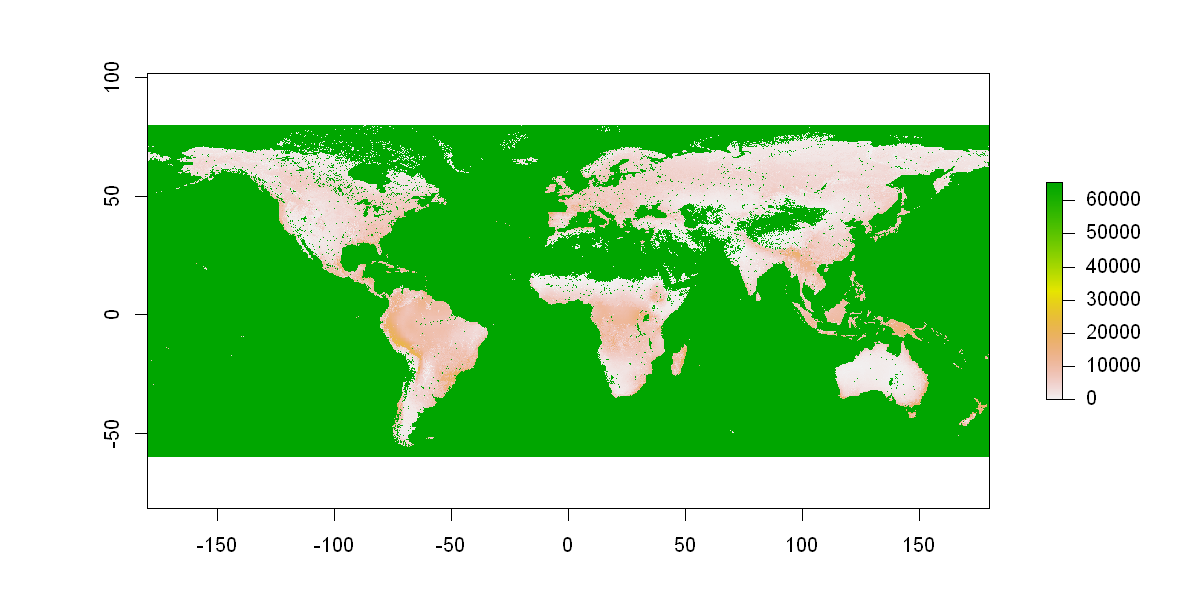

In [6]:
options(repr.plot.width = 10, repr.plot.height = 5)
plot(raw_npp)

As detailed in the documentation of the source, the map contains fill values (for NAs, water, error areas, etc...) codified with values above 32699.  
Also, the data needs to be multiplied by 0.1 to obtain the actual values in g C / m / year.

Finally, aggregate cells to reduce the resolution to 10x10km

In [8]:
#remove fill values, transform to g C / m / year
clean_npp <- reclassify(raw_npp, matrix(c(32699, 100000, NA), ncol = 3))*0.1 

#aggregate to 10x10km
clean_npp <- aggregate(clean_npp, fact=10, fun=mean) 

clean_npp

class      : RasterLayer 
dimensions : 1680, 4320, 7257600  (nrow, ncol, ncell)
resolution : 0.08333333, 0.08333333  (x, y)
extent     : -180, 180, -60, 80  (xmin, xmax, ymin, ymax)
crs        : +proj=longlat +datum=WGS84 +no_defs +ellps=WGS84 +towgs84=0,0,0 
source     : C:/Users/Angel/AppData/Local/Temp/RtmpwZso7C/raster/r_tmp_2020-09-11_113209_3064_53703.grd 
names      : MOD17A3_Science_NPP_mean_00_15 
values     : 0, 2519.956  (min, max)


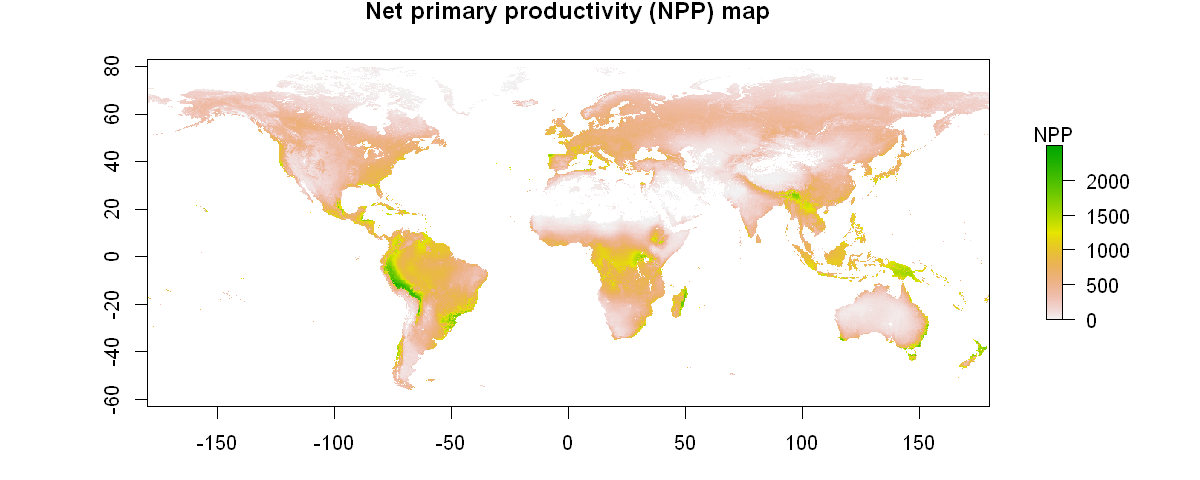

In [22]:
plot(clean_npp, main="Net primary productivity (NPP) map\nas gr C / m^2 / year",legend.args = list(text = 'NPP'))

### Create sample points
Create a sampling of 35,000 random points across the surface with NPP data available. This amount of samples provides enough data to build acceptable models without boosting the processing times.
A greater number of points should produce slightly more accurate models, helping capture more of the natural variation in NPP, but becomes much more computationally expensive.

In [11]:
set.seed(seed)
sample_points <- randomPoints(mask=clean_npp, n = 35000)

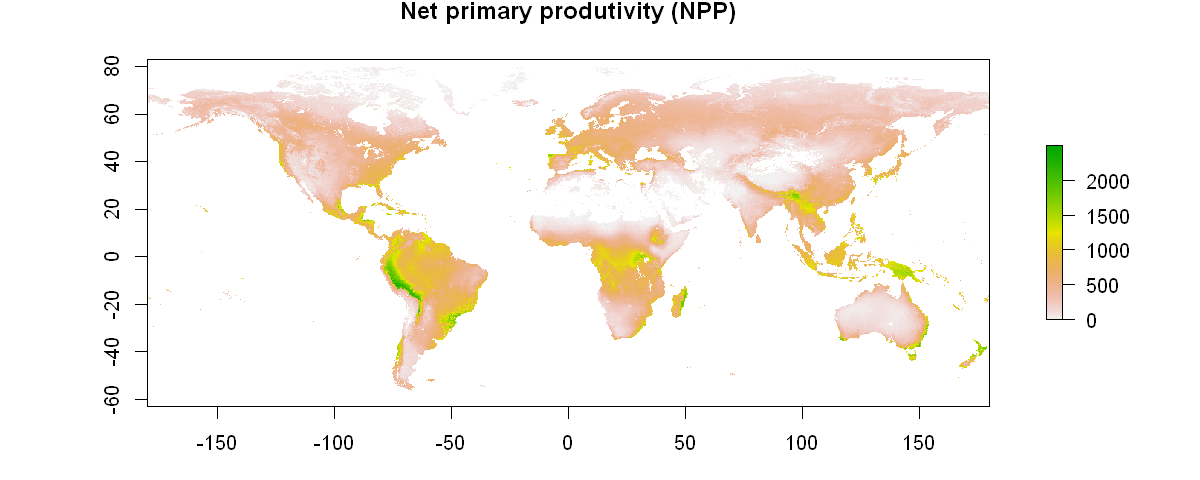

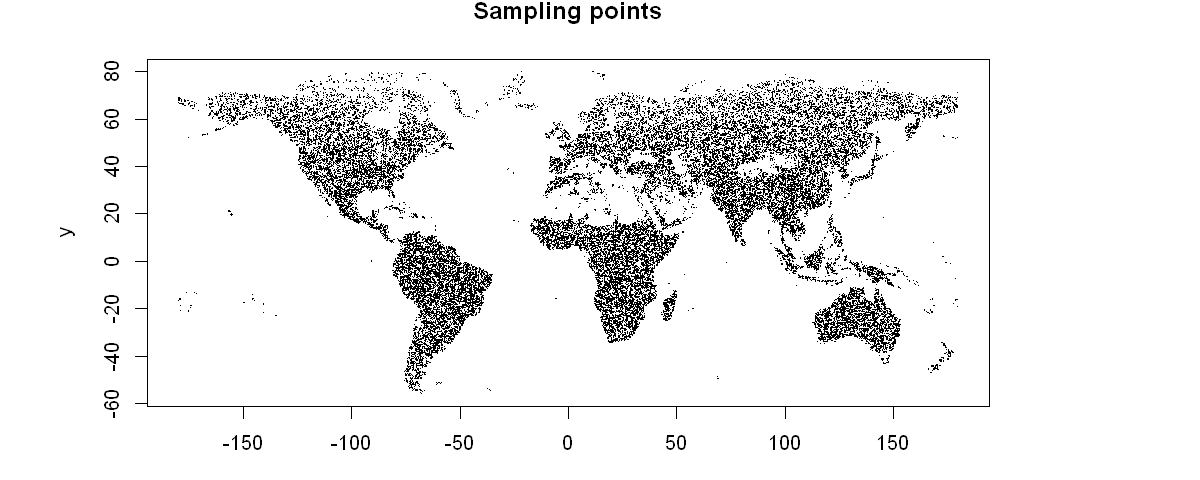

In [26]:
options(repr.plot.width = 10, repr.plot.height = 4)
plot(clean_npp, main = "Net primary produtivity (NPP)")
plot(sample_points, pch = ".", main="Sampling points")

Transform the points into a data frame containing only the latitude ('y') and longitude ('x') coordinates values.

In [28]:
points_df <- as.data.frame(sample_points)
head(points_df, 5)

x,y
<dbl>,<dbl>
-51.70833,-30.45833
-59.62500,-3.62500
157.29167,56.20833
-13.54167,10.29167
51.12500,30.20833


### Extract NPP data

For each sampling point, extract the corresponding NPP data from the NPP map. 

In [29]:
NPP_df <- data.frame(raster::extract(clean_npp, sample_points))
colnames(NPP_df) <- "NPP"
points_df <- cbind(points_df, NPP_df)
head(points_df, 5)

x,y,NPP
<dbl>,<dbl>,<dbl>
-51.70833,-30.45833,1539.879
-59.62500,-3.62500,773.072
157.29167,56.20833,442.138
-13.54167,10.29167,307.621
51.12500,30.20833,52.743


### Generate Miami Model map

Use the mean annual temperature and annual precipitation to generate a map of potential NPP based on the Miami Model 

Create a list of the [bioclimatic maps](https://www.worldclim.org/data/bioclim.html) files.

In [30]:
list_bioclim <- list.files(path_bioclim, pattern = "*.tif")
list_bioclim[1:3]

[1] "wc2.1_5m_bio_1.tif"  "wc2.1_5m_bio_10.tif" "wc2.1_5m_bio_11.tif"

Load mean annual temperature (bio_1) and annual precipitation (bio_12)

In [72]:
bio_tmean <- raster(file.path(path_bioclim, list_bioclim[grep("bio_1.tif", list_bioclim)])) #Annual mean temp in ºCx10
bio_prec <- raster(file.path(path_bioclim, list_bioclim[grep("bio_12.tif", list_bioclim)])) #Annual precipitation in mm

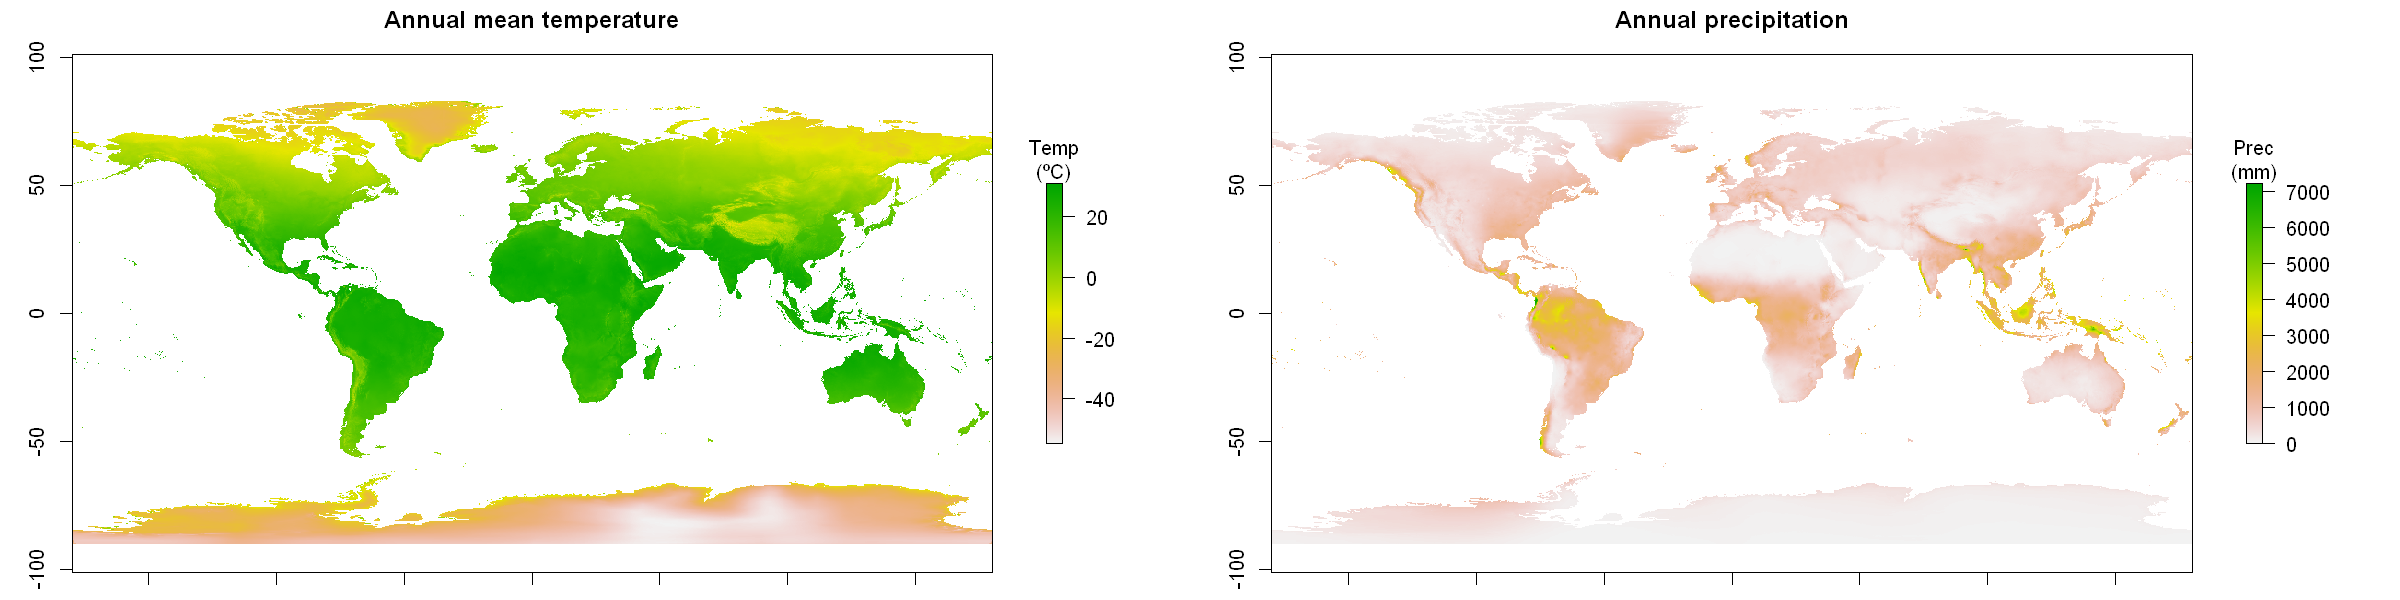

In [42]:
options(repr.plot.width = 20, repr.plot.height = 5)
par(mfrow=c(1,2), mar=c(1.5,1,3,2))
plot(bio_tmean, main="Annual mean temperature", legend.args = list(text = "Temp\n(ºC)"))
plot(bio_prec, main="Annual precipitation", legend.args = list(text = "Prec\n(mm)"))
par(mfrow=c(1,1))

Now, apply the formulas of the Miami Model to the temprature and precipitation files to obtain separate potential NPP maps for each variable.  
The formulas are those retrieved from the `Miami_model_functions.R` script at the beggining of the code.

In [73]:
print("Formula for temperature")
NPP_temp
print("Formula for precipitation")
NPP_prec

[1] "Formula for temperature"


function (temp) 
{
    3000/(1 + exp(1.315 - 0.119 * temp))
}
<bytecode: 0x0000000025245a38>

[1] "Formula for precipitation"


function (prec) 
{
    3000 * (1 - exp(-0.000664 * prec))
}
<bytecode: 0x00000000252536b8>

The function `raster::beginCluster` helps with the computation times a bit.

In [74]:
beginCluster()
npp_tmean_miami <- calc(bio_tmean, NPP_temp)
npp_prec_miami <- calc(bio_prec, NPP_prec)

npp_brick <- brick(npp_tmean_miami, npp_prec_miami)
message("NPP finished")
endCluster()

12 cores detected, using 11

NPP finished



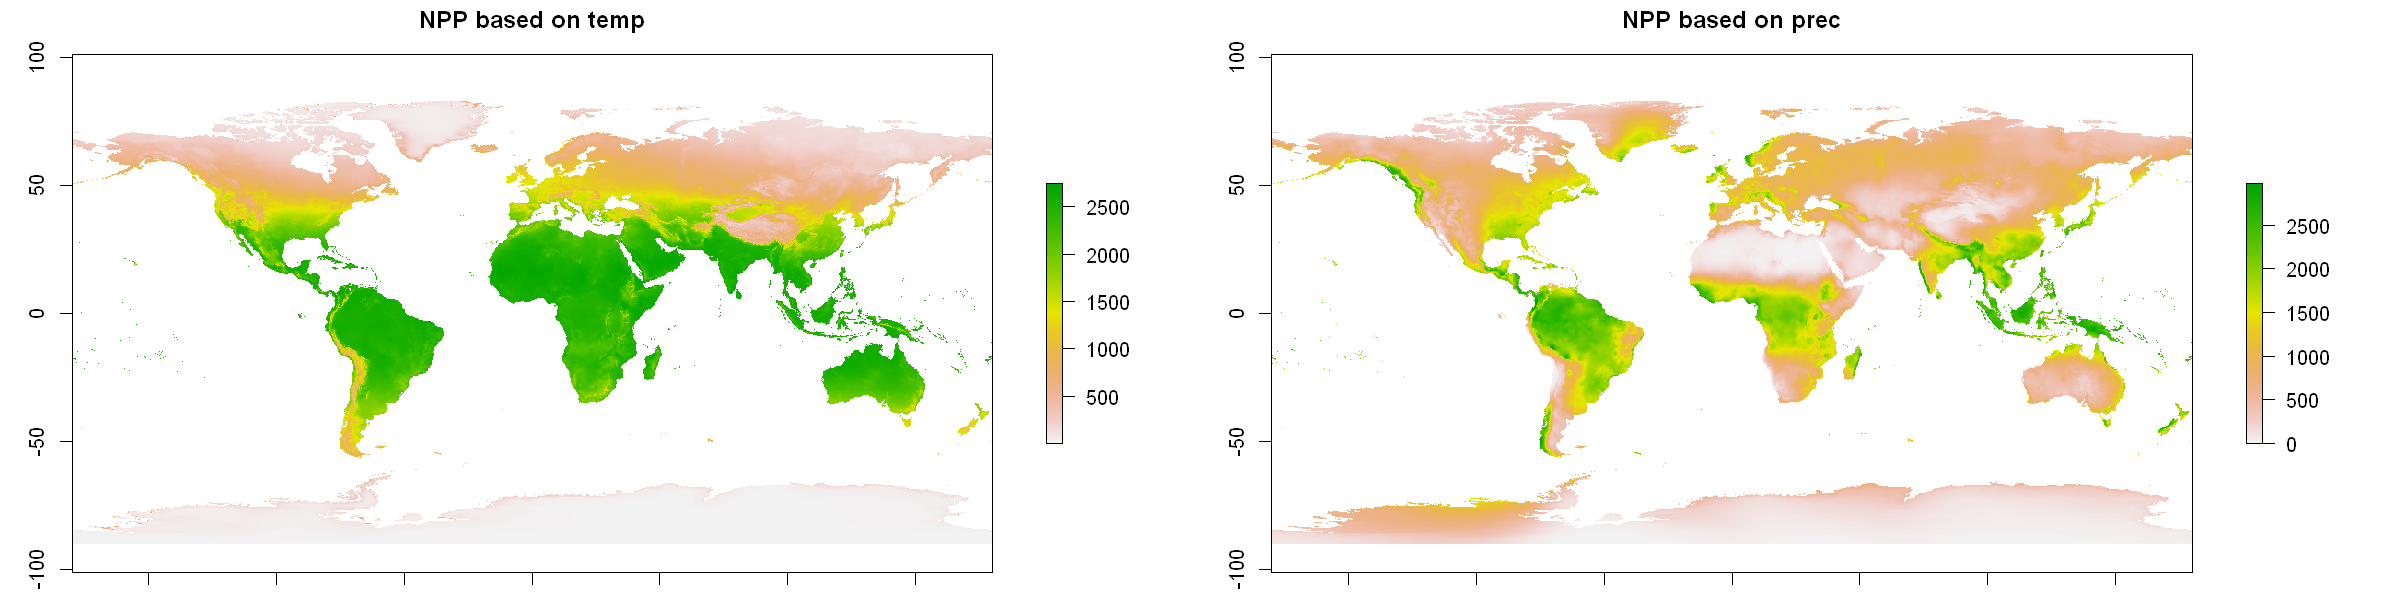

In [46]:
options(repr.plot.width = 20, repr.plot.height = 5)
par(mfrow=c(1,2), mar=c(1.5,1,3,2))
plot(npp_brick[[1]], main="NPP based on temp")
plot(npp_brick[[2]], main="NPP based on prec")
par(mfrow=c(1,1))

In [58]:
par(mar=c(5.1, 4.1, 4.1, 2.1))

Now, just combine both predictions and obtain a map with the minimum value for each cell as final prediction.  
This is because, accoroding to the model, in each location the NPP value corresponds to the estimation from the factor that is limiting it the most (temperature or precipitation)

In [47]:
beginCluster()
npp_miami <- calc(npp_brick, min)
endCluster()

12 cores detected, using 11



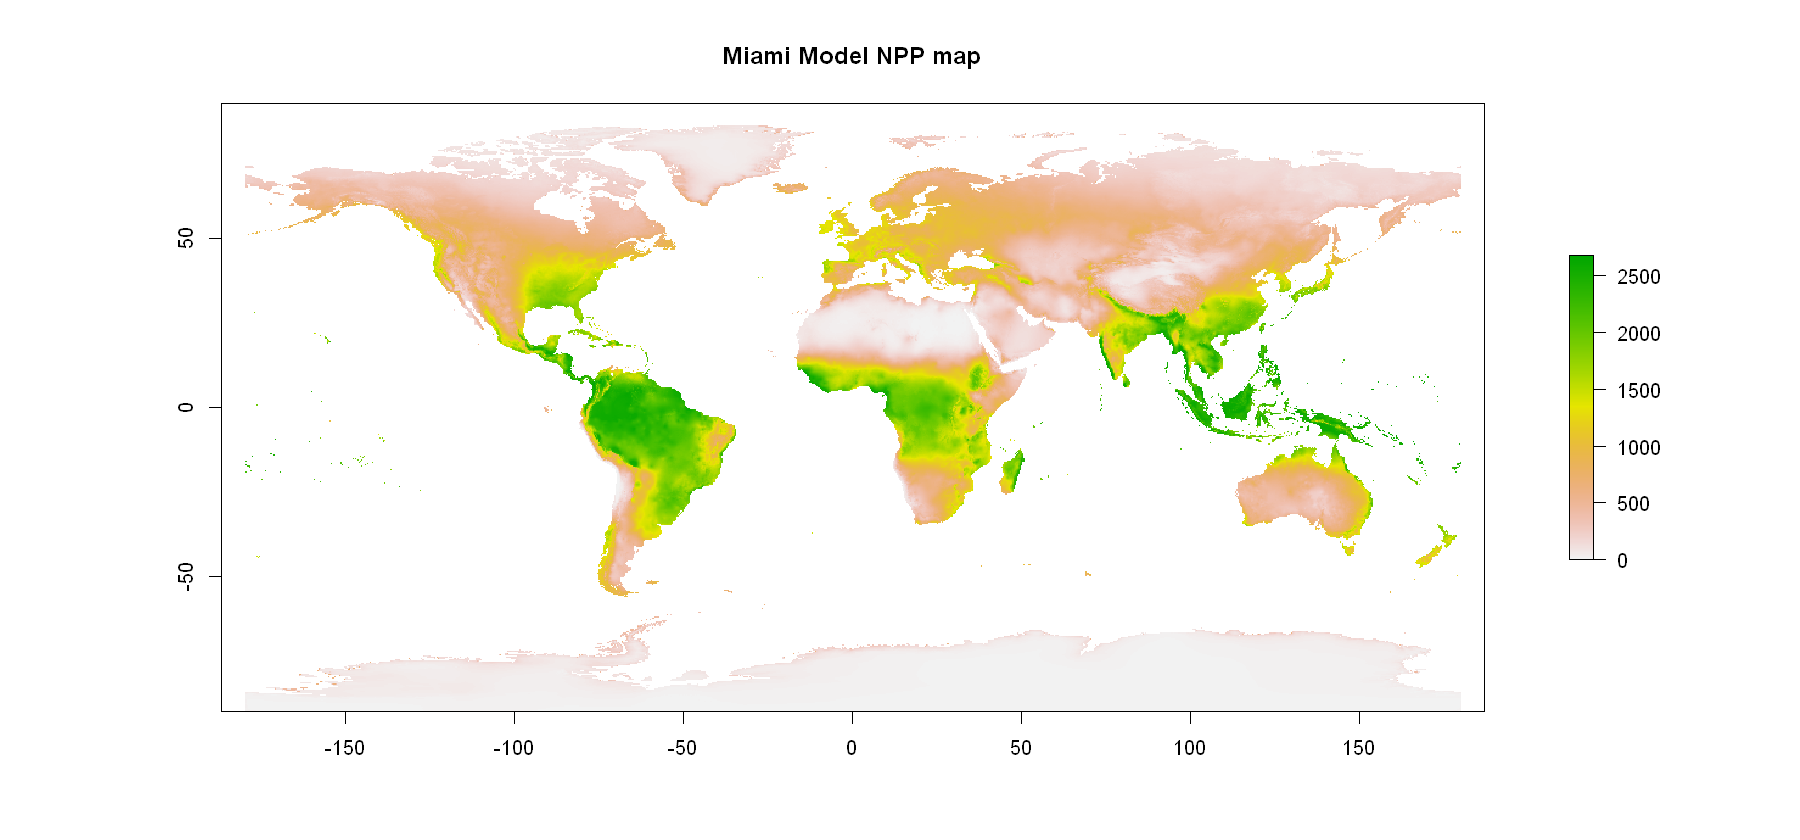

In [62]:
options(repr.plot.width = 15, repr.plot.height = 7)
plot(npp_miami, main="Miami Model NPP map")

**A little comparison between the 'real' data and the Miami Model**

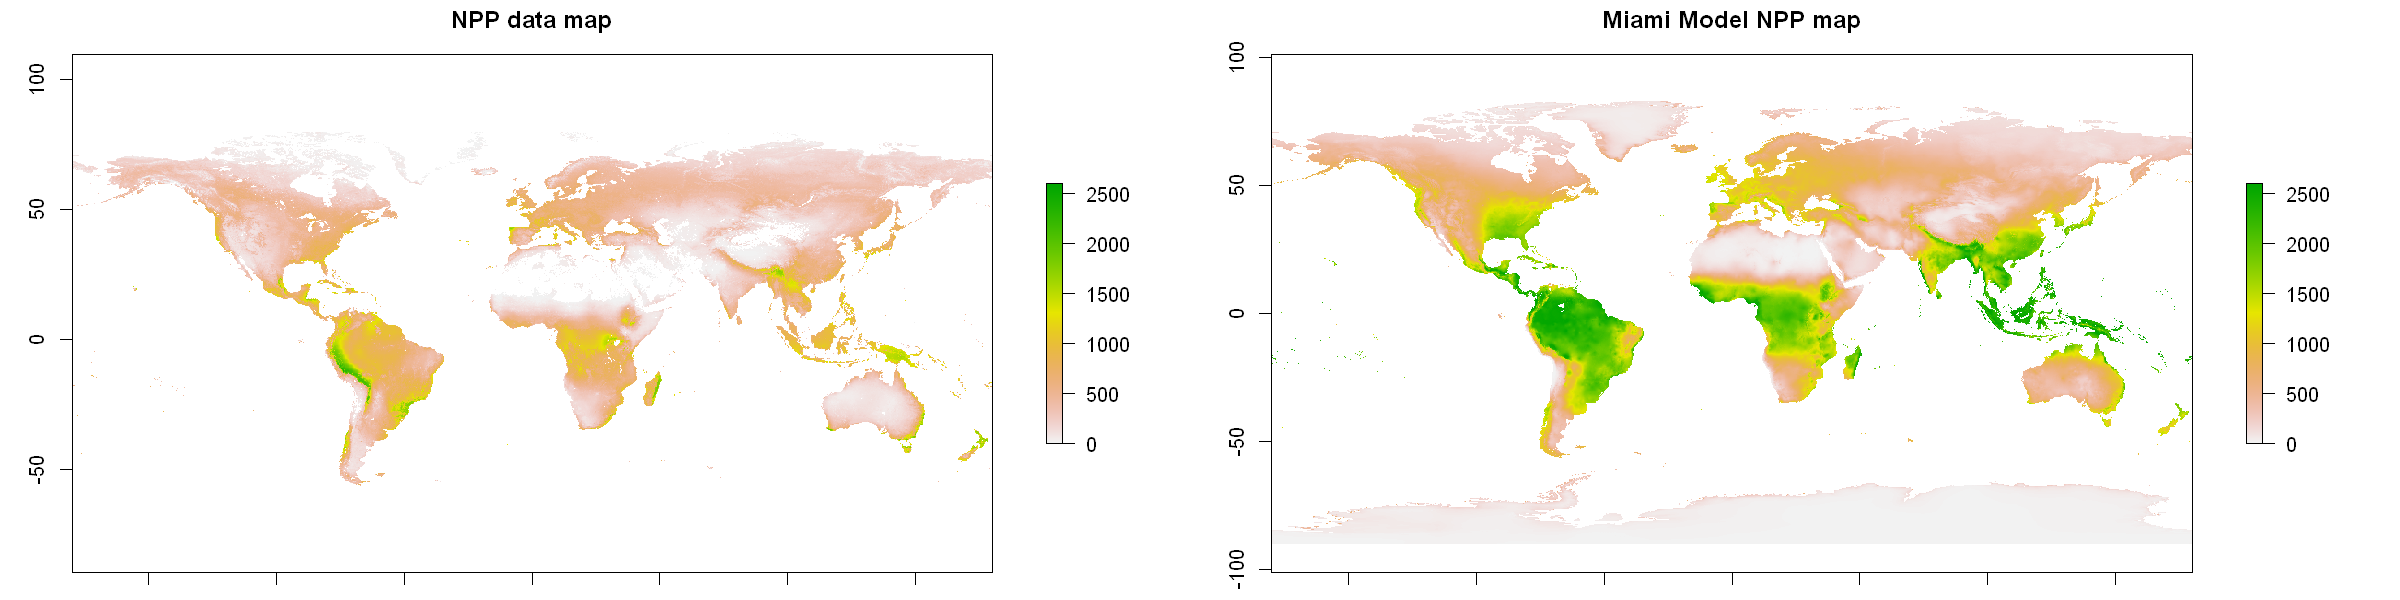

In [63]:
options(repr.plot.width = 20, repr.plot.height = 5)
par(mfrow=c(1,2), mar=c(1.5,1,3,2))
plot(clean_npp, main="NPP data map", zlim=c(0,2600))
plot(npp_miami, main="Miami Model NPP map", zlim=c(0,2600))
par(mfrow=c(1,1))

Save the Miami Model map and remove unneeded temporal maps.

In [64]:
#writeRaster(npp_miami, file.path(path_project, "NPP_miami_model","NPP_miami_model.tif"))
rm(bio_tmean, bio_prec, npp_prec_miami, npp_tmean_miami, npp_brick)#, npp_miami)

### Extract Miami Model data into the main dataframe

In [65]:
#npp_miami <- raster(file.path(path_project, "NPP_miami_model","NPP_miami_model.tif"))

NPP_miami_df <- data.frame(raster::extract(npp_miami, sample_points))
colnames(NPP_miami_df) <- "Miami_NPP"

points_df <- cbind(points_df, NPP_miami_df)
head(points_df, 5)

x,y,NPP,Miami_NPP
<dbl>,<dbl>,<dbl>,<dbl>
-51.70833,-30.45833,1539.879,1862.1138
-59.62500,-3.62500,773.072,2321.6444
157.29167,56.20833,442.138,523.6858
-13.54167,10.29167,307.621,2577.7593
51.12500,30.20833,52.743,474.0019


### Extract bioclimatic data

Extract the data for each of the 19 bioclimatic variables (maps) into the main dataframe to complete the main database for the analyses.  

This is done using a _for_ loop to load each map, extract the data and combine it with the main dataframe

In [66]:
for(i in 1:length(list_bioclim)){
  #Load a bioclim map
  map_data <- raster(file.path(path_bioclim, list_bioclim[i]))
  #Extract data
  bioclim_df <- data.frame(raster::extract(map_data, sample_points))
  #Rename to match the bioclim name
  var_name <- strsplit(list_bioclim[i], "_") %>% unlist() %>% grep(".tif", ., value = T) %>% sub(".tif", "", .)
  colnames(bioclim_df) <- paste0("bio_", var_name)
  #Join with the main dataframe
  points_df <- cbind(points_df, bioclim_df)
  message(i, "/19 completed")
}

1/19 completed

2/19 completed

3/19 completed

4/19 completed

5/19 completed

6/19 completed

7/19 completed

8/19 completed

9/19 completed

10/19 completed

11/19 completed

12/19 completed

13/19 completed

14/19 completed

15/19 completed

16/19 completed

17/19 completed

18/19 completed

19/19 completed



### Final data
Visualize the final dataframe and save it for the exploration and analyses.

In [70]:
message(paste0("Dataframe has ", nrow(points_df), " rows and ", ncol(points_df), " columns"))
head(points_df, 10)


Dataframe has 35000 rows and 23 columns



x,y,NPP,Miami_NPP,bio_1,bio_10,bio_11,bio_12,bio_13,bio_14,...,bio_18,bio_19,bio_2,bio_3,bio_4,bio_5,bio_6,bio_7,bio_8,bio_9
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
-51.70833,-30.458333,1539.879,1862.1138,18.293459,22.49333,13.71750,1460,137,105,...,407,366,8.553917,47.09529,371.62753,27.512,9.349,18.163,22.493334,20.22250
-59.62500,-3.625000,773.072,2321.6444,26.900417,27.60050,26.39317,2239,281,79,...,378,826,8.279500,80.76774,48.99479,32.327,22.076,10.251,26.460333,27.13983
157.29167,56.208333,442.138,523.6858,-2.005333,10.44883,-14.44367,558,85,16,...,201,80,9.464000,25.72788,1033.16968,15.979,-20.806,36.785,6.574167,-10.00717
-13.54167,10.291667,307.621,2577.7593,28.262793,30.96000,26.67867,2953,912,0,...,155,2124,11.071250,58.65563,179.47609,38.264,19.389,18.875,26.678667,28.70900
51.12500,30.208333,52.743,474.0019,22.512041,33.37067,11.70800,259,68,0,...,2,141,14.251750,38.11750,882.29053,42.757,5.368,37.389,12.413333,32.83383
92.62500,23.875000,950.781,2307.0765,23.214043,26.05717,18.00367,2207,432,5,...,1091,46,9.813416,47.93814,345.75806,31.031,10.560,20.471,26.057167,18.00367
-39.95833,-18.875000,1224.173,1666.4184,23.721209,25.95300,21.32917,1221,173,43,...,359,160,9.585750,62.52119,187.42259,31.138,15.806,15.332,25.102501,21.32917
65.95833,32.708333,121.840,457.1734,13.903167,26.23683,1.08500,249,65,0,...,1,142,16.916666,38.04576,1001.69824,37.180,-7.284,44.464,2.984333,26.23683
18.29167,-19.625000,295.954,814.4133,21.681334,25.38783,16.43250,477,125,0,...,116,2,15.350833,57.58866,377.96167,32.856,6.200,26.656,23.927166,16.43250


In [ ]:
write.csv(points_df, file.path(path_project,"35k_data.csv"), row.names = F, )